### Objective: To calculate charge changes across the board and fit models. 

In [1]:
import pandas as pd
import seaborn as sns

from developability.utils import ls
from developability import data as data_
from pathlib import Path
from collections import  defaultdict
from matplotlib import pyplot as plt
data_path = Path(data_.__path__[0])
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from itables import show
%config InlineBackend.figure_format= 'retina'


In [2]:
fname = data_path/'processed/descriptors_with_metadata_for_internal_antibodies_predicted_04-26-2024.parquet'
df =pd.read_parquet(fname)

# remove seqs that do not belong. 

remove = ['VIRMAB-MPK176-R1-135','VIRMAB-MPK176-R1-3','VIRMAB-MPK65-R1-3','VIRMAB-ML-M190-R2-080','VIRMAB-MPK65-R1-6']
df = df.loc[~df.index.isin(remove)]
df.head()


,dataset,Project,VH,VL,Heparin RRT,HeparinRRT_scaled,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,...,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
VIRMAB-ML-P38-11,test,PIA38,QVQLVQSGAEVKKPGSSVKVSCKASGDIFGSYALSWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSLSRNSLAWYQQKPGQAPR...,0.994,NaN,80.172153,-1116.471856,-1036.299703,621.886165,...,3223.840120,4090.958531,-19330.239328,-15239.280797,19577.486822,-10195.097389,9382.389433,23668.445352,-29525.336717,-5856.891365
VIRMAB-ML-P38-12,test,PIA38,QVQLVQSGAEVKKPGSSVKVSCKASGDIFGSYALSWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSLSRNSLAWYQQKPGQAPR...,0.997,NaN,111.680341,-825.707611,-714.027270,1603.214680,...,11963.512998,7292.299432,-11267.480851,-3975.181419,26954.907245,-6596.305523,20358.601723,34247.206678,-17863.786374,16383.420304
VIRMAB-ML-P38-13,test,PIA38,QVQLVQSGAEVKKPGSSVKVSCKASGDIFGSYALSWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSLSRNSLAWYQQKPGQAPR...,0.998,NaN,74.348461,-819.897488,-745.549027,1462.244423,...,12193.243930,6443.946393,-12861.827853,-6417.881460,26977.236697,-6627.023157,20350.213540,33421.183091,-19488.851010,13932.332081
VIRMAB-ML-P38-14,test,PIA38,QVQLVQSGAEVKKPGSSVKVSCKASGDIFGSYALSWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSLSRNSLAWYQQKPGQAPR...,0.995,NaN,66.743449,-891.763968,-825.020519,1475.123714,...,9238.538060,5988.878412,-14913.345725,-8924.467312,27671.411927,-6445.110009,21226.301918,33660.290339,-21358.455734,12301.834606
VIRMAB-ML-P38-15,test,PIA38,QVQLVQSGAEVKKPGSSVKVSCKASGDIFGSYALSWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSLSRNSLAWYQQKPGQAPR...,0.995,NaN,53.867664,-976.261268,-922.393604,1616.247932,...,11932.242680,6732.300682,-14698.175103,-7965.874421,28810.015565,-5888.853301,22921.162264,35542.316247,-20587.028404,14955.287843


In [3]:
df['Project'].value_counts()

Project
MPK190     180
MPK201     130
MPK65      130
MPK176     129
RSD5       127
PIA38       86
FNI9v81     17
Name: count, dtype: int64

In [4]:
cols = df.columns[6:]
df[cols].corrwith(df['HeparinRRT_scaled']).sort_values(ascending=False).head(10)

HFR3_APBS_pos         0.668584
HCDR2_APBS_pos        0.666686
TOTAL_CDR_APBS_pos    0.651286
HC_APBS_pos           0.636749
HC_APBS_net           0.621372
LCDR3_APBS_pos        0.619204
TOTAL_CDR_APBS_net    0.618138
HFR3_APBS_net         0.614458
LCDR1_APBS_pos        0.607619
HCDR_APBS_pos         0.598280
dtype: float64

In [5]:


def consensus(sequences):
    counts = {}
    for seq in sequences: 
        for i, c in enumerate(seq): 
            counts.setdefault(i,{})
            counts[i].setdefault(c, 0)
            counts[i][c]+=1
    

    consensus_seq=[]
    for i in counts: 
        pos_count = [(item, key) for key, item in counts[i].items()]
        pos_count.sort(reverse=True)
        consensus_seq.append(pos_count[0][1])
    return ''.join(consensus_seq)


def count_changes(s1, s2): 
    ## assume same lenght
    return sum(1 for c1,c2 in zip(s1,s2) if c1!=c2)

def calc_charge(s):
    def zero(): return 0
    charges = defaultdict(zero,{'D':-1, 'E':-1, 'R':1,'K':1})
    return sum(charges[c] for c in s)


def calc_charge_change(seqs): 
    consensus_seq = consensus(seqs)
    charges = seqs.apply(calc_charge)-calc_charge(consensus_seq)
    return charges

def count_seq_changes(seqs):
    consensus_seq = consensus(seqs)
    changes = seqs.apply(lambda x: count_changes(consensus_seq, x))
    return changes


def calc_charge_pH7(seqs): 
    return seqs.apply(lambda x: IP(x).charge_at_pH(7.0))


def consensus_grid(sequences): 
    counts = {}
    for seq in sequences: 
        for i, c in enumerate(seq): 
            counts.setdefault(i,{})
            counts[i].setdefault(c, 0)
            counts[i][c]+=1
    return pd.DataFrame(counts)


def concensus_index(seqs): 
    consensus_seq = consensus(seqs)
    return list(seqs.index[seqs==consensus_seq])

In [6]:
grouped = df.groupby('Project')
vh_charge_changes = grouped['VH'].apply(calc_charge_change)
vh_seq_changes = grouped['VH'].apply(count_seq_changes)

vl_charge_changes = grouped['VL'].apply(calc_charge_change)
vl_seq_changes = grouped['VL'].apply(count_seq_changes)

vh_ph7 = grouped['VH'].apply(calc_charge_pH7)
vl_ph7 = grouped['VL'].apply(calc_charge_pH7)


vh_consensus_seq = grouped['VH'].apply(concensus_index)
vl_consensus_seq = grouped['VL'].apply(concensus_index)


parent_seqs = []

for seqs1, seq2 in zip(vh_consensus_seq ,vl_consensus_seq): 
    parent = set(seqs1).intersection(set(seq2))
    if parent:
        parent_seqs.append(list(parent)[0])
    else:
        parent_seqs.append(seq2[0])
    
parent_seqs_map = dict(zip(vh_consensus_seq.index, parent_seqs))
parent_seqs_map

{'FNI9v81': 'VIRMAB-FNI9-R1-23',
 'MPK176': 'VIRMAB-MPK176-R1-2',
 'MPK190': 'VIRMAB-ML-M190-R2-035',
 'MPK201': 'VIRMAB-MPK201-R1-1',
 'MPK65': 'VIRMAB-MPK65-R1-2',
 'PIA38': 'VIRMAB-ML-P38-94',
 'RSD5': 'VIRMAB-RSD5-R1-2'}

In [7]:
changes_df = pd.concat([vh_charge_changes, vh_seq_changes, vl_charge_changes, vl_seq_changes,
                        vh_ph7, vl_ph7], axis = 1)
changes_df.columns = ['dChargeVH', 'dSeqVH', 'dChargeVL', 'dSeqVL','pH7VH','pH7VL']
changes_df['dCharge'] = changes_df['dChargeVH'] + changes_df['dChargeVL']
changes_df['dSeq'] = changes_df['dSeqVH'] + changes_df['dSeqVL']
changes_df['Charge_pH7'] = changes_df['pH7VH'] +changes_df['pH7VL']
changes_df

dChargeVH  dSeqVH  dChargeVL  dSeqVL     pH7VH  \
Project                                                                     
FNI9v81 VIRMAB-FNI9-R1-23         -1       1          0       0 -0.439895   
        VIRMAB-FNI9-R1-24          0       0         -1       1  0.558984   
        VIRMAB-FNI9-R1-25          0       0         -1       1  0.558984   
        VIRMAB-FNI9-R1-26          0       0         -1       1  0.558984   
        VIRMAB-FNI9-R1-27          0       0         -1       1  0.558984   
...                              ...     ...        ...     ...       ...   
RSD5    VIRMAB-RSD5-R1-94          0       1          0       0  6.551027   
        VIRMAB-RSD5-R1-95          0       0          1       1  6.551027   
        VIRMAB-RSD5-R1-96          0       1          0       0  6.551027   
        VIRMAB-RSD5-R1-97          0       0          1       1  6.551027   
        VIRMAB-RSD5-R1-98          0       0          0       1  6.551027   

                              pH7VL  dCharge  dSeq  Charge_pH7  
Project                                                         
FNI9v81 VIRMAB-FNI9-R1-23  0.980361       -1     1    0.540466  
        VIRMAB-FNI9-R1-24 -0.016828       -1     1    0.542156  
        VIRMAB-FNI9-R1-25 -0.018518       -1     1    0.540466  
        VIRMAB-FNI9-R1-26 -0.018518       -1     1    0.540466  
        VIRMAB-FNI9-R1-27 -0.016828       -1     1    0.542156  
...                             ...      ...   ...         ...  
RSD5    VIRMAB-RSD5-R1-94 -2.017328        0     1    4.533699  
        VIRMAB-RSD5-R1-95 -1.017338        1     1    5.533689  
        VIRMAB-RSD5-R1-96 -2.017328        0     1    4.533699  
        VIRMAB-RSD5-R1-97 -1.018449        1     1    5.532578  
        VIRMAB-RSD5-R1-98 -2.017328        0     1    4.533699  

[799 rows x 9 columns]

In [8]:
total_changes_df = (changes_df.iloc[:, -3:].reset_index()
                    .rename(columns = {'level_1':'Antibody'})
                    )
total_changes_df.head()

,Project,Antibody,dCharge,dSeq,Charge_pH7
0,FNI9v81,VIRMAB-FNI9-R1-23,-1,1,0.540466
1,FNI9v81,VIRMAB-FNI9-R1-24,-1,1,0.542156
2,FNI9v81,VIRMAB-FNI9-R1-25,-1,1,0.540466
3,FNI9v81,VIRMAB-FNI9-R1-26,-1,1,0.540466
4,FNI9v81,VIRMAB-FNI9-R1-27,-1,1,0.542156


In [9]:
df_subset = (df.copy()
             .query('dataset=="train_validation"')
             .reset_index()
             .rename(columns={'index':'Antibody'})
             [['Project', 'Antibody','HeparinRRT_scaled', 'TOTAL_CDR_APBS_pos']]
             )

train = df_subset.merge(total_changes_df)
train = train.set_index('Antibody')
             

In [10]:
min_changes = train.groupby('Project').dSeq.idxmin()
project_to_seq = dict(zip(min_changes.index, min_changes.values))
project_to_seq
    


{'FNI9v81': 'VIRMAB-FNI9-R1-23',
 'MPK176': 'VIRMAB-MPK176-R1-2',
 'MPK190': 'VIRMAB-ML-M190-R2-035',
 'MPK201': 'VIRMAB-MPK201-R1-1',
 'MPK65': 'VIRMAB-MPK65-R1-2',
 'RSD5': 'VIRMAB-RSD5-R1-2'}

In [11]:
# maps 
project_to_cdr = {project: train.loc[name]['TOTAL_CDR_APBS_pos'] for project, name in project_to_seq.items()}
project_to_charge7 = {project: train.loc[name]['Charge_pH7'] for project, name in project_to_seq.items()}

train['dTOTAL_CDR_APBS_pos']= train['TOTAL_CDR_APBS_pos']- train['Project'].map(project_to_cdr)
train['dCharge_pH7']=train['Charge_pH7']- train['Project'].map(project_to_charge7)

### Plot a pair plot 

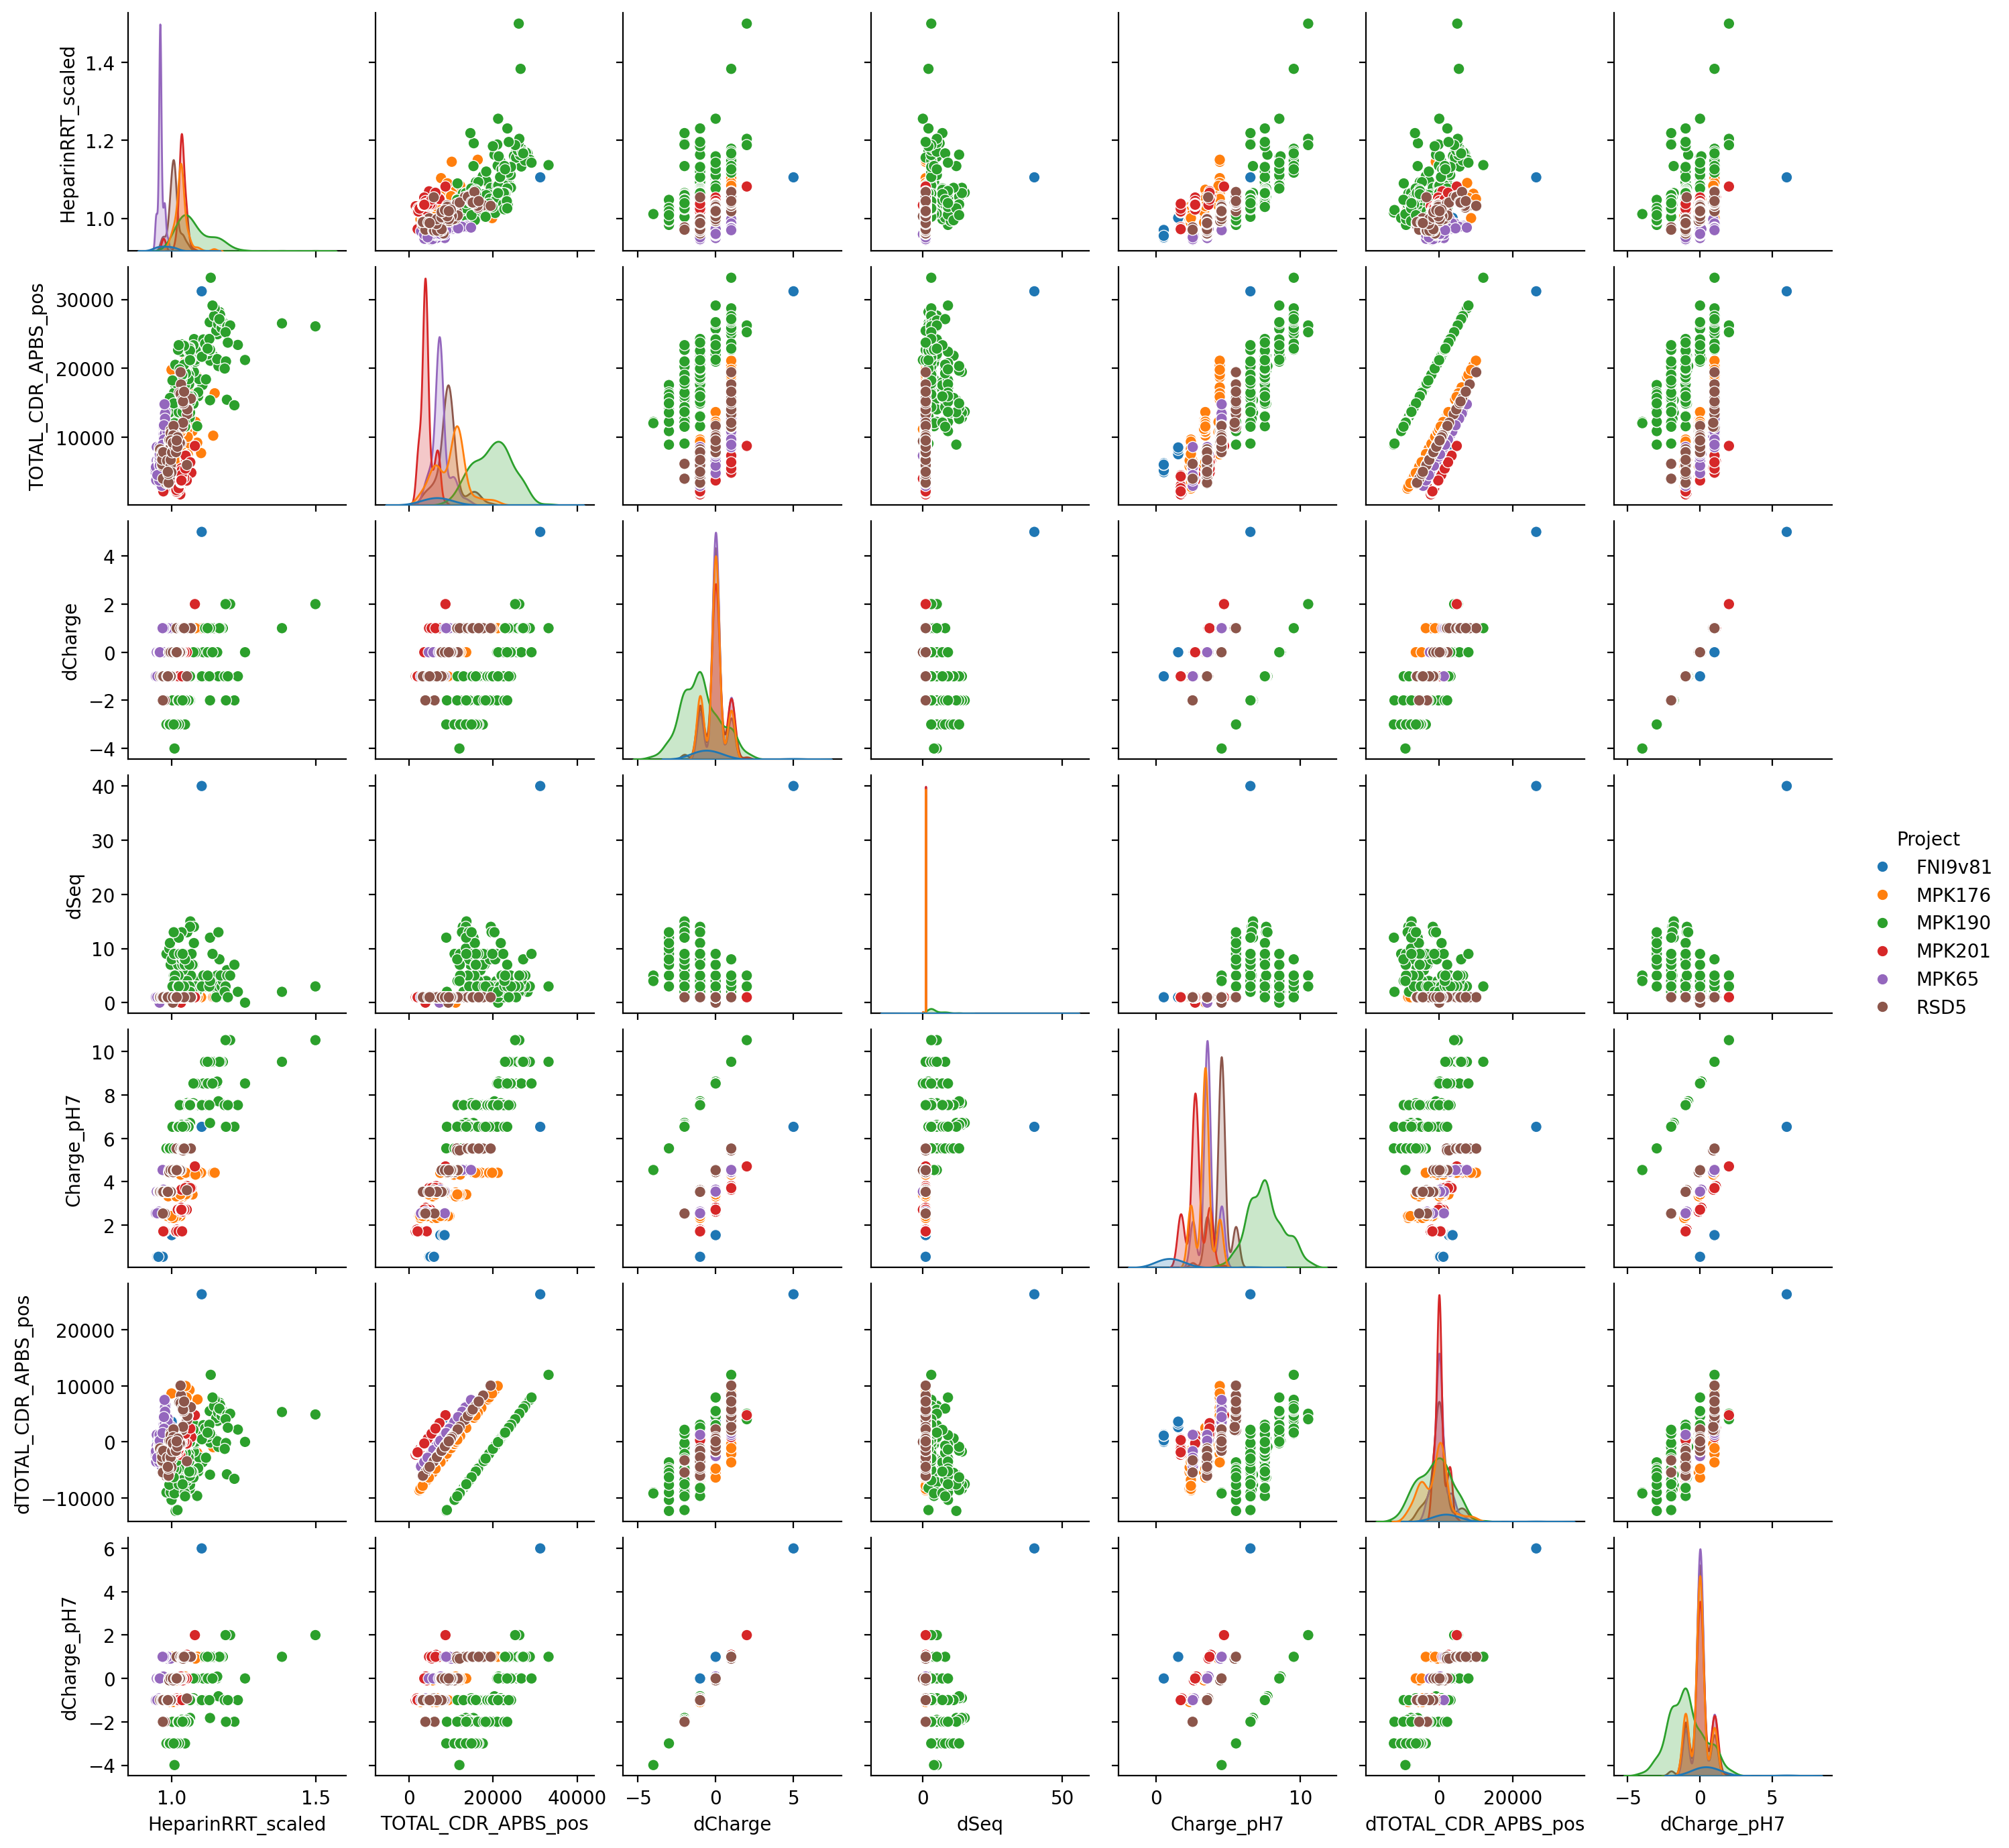

In [12]:
sns.pairplot(train, vars = train.columns[1:], height = 2, hue = 'Project')

In [13]:
train.columns

Index(['Project', 'HeparinRRT_scaled', 'TOTAL_CDR_APBS_pos', 'dCharge', 'dSeq',
       'Charge_pH7', 'dTOTAL_CDR_APBS_pos', 'dCharge_pH7'],
      dtype='object')

In [37]:
def predict(project,models, x= 'dCharge',y='HeparinRRT_scaled', train=train): 
    X = train.query('Project==@project')
    model = models[project]

    preds = np.ravel( model.predict(X[[x]]))
    res = pd.DataFrame(dict(Y_true = X[y].values, Y_pred =preds))
    res.insert(0, 'Parent', project)
    return res

def score(parent, models, x='dCharge',y='HeparinRRT_scaled'): 
    preds = predict(parent,models, x,y)

    r2 = r2_score(preds['Y_true'], preds['Y_pred'])
    spearman = preds.iloc[:, 1:].corr(method = 'spearman').iloc[1,0]
    pearson = preds.iloc[:, 1:].corr(method = 'pearson').iloc[1,0]
    res=pd.DataFrame(dict(r2=r2, spearman = spearman, pearson=pearson), index = [parent])
    return res

    
def train_models(x, y='HeparinRRT_scaled', train = train):
    models = {}
    project = train.Project.unique()
    
    for project in train.Project.unique():
        df=train.copy().query('Project!=@project')
        model = LinearRegression()
        model.fit(df[[x]], df[[y]])
        models[project] = model
    return models



### Create Models and score for each 

In [38]:
projects = train.Project.unique()
models_d = {}
preds_d={}
scores_d = {}
for x in [ 'dCharge','TOTAL_CDR_APBS_pos', 'dTOTAL_CDR_APBS_pos','Charge_pH7' ,'dCharge_pH7']:
    models = train_models(x =x)
    models_d[x] =models
    preds_d[x] = pd.concat([predict(project, models, x=x) for project in projects])
    scores_d[x] = pd.concat([score(project, models, x=x) for project in projects])



In [40]:
test =scores_d['dCharge']
test['Mean'] = test.mean(axis=0)
test.unstack()

r2        FNI9v81    -0.785638
          MPK176      0.213813
          MPK190     -1.555503
          MPK201      0.337694
          MPK65     -77.909334
          RSD5       -1.386812
spearman  FNI9v81     0.889438
          MPK176      0.756223
          MPK190      0.804270
          MPK201      0.830419
          MPK65       0.791456
          RSD5        0.757920
pearson   FNI9v81     0.954779
          MPK176      0.726758
          MPK190      0.726500
          MPK201      0.783465
          MPK65       0.874433
          RSD5        0.805265
Mean      FNI9v81          NaN
          MPK176           NaN
          MPK190           NaN
          MPK201           NaN
          MPK65            NaN
          RSD5             NaN
dtype: float64

In [33]:

scores_df = pd.concat([s.unstack() for s in scores_d.values()], axis = 1).T.round(3)
scores_df.index = list(scores_d.keys())
show(scores_df)


ValueError: Columns with duplicate values are not supported in stack